Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [2]:
%%capture
import sys

# # If you're on Colab:
# if 'google.colab' in sys.modules:
#     DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
#     !pip install category_encoders==2.*
#     !pip install eli5
#     !pip install pdpbox

# # If you're working locally:
# else:
#     DATA_PATH = '../data/'

In [3]:
import pandas as pd
import numpy as np
dataurl = 'https://raw.githubusercontent.com/Nckflannery/Unit2-Project/master/Data/NFL%20Combine%20Data%20-%20Combine%20Results.csv'
colnames = ['Year', 'Name', 'YearName', 'College', 'POS', 'Height',
       'Weight', 'Hand Size', 'Arm Length', 'Wonderlic',
       '40 Yard', 'Bench Press', 'Vert Leap', 'Broad Jump',
       'Shuttle', '3Cone', '60Yd Shuttle', 'Pick', 'Round']
df=pd.read_csv(dataurl, names=colnames, skiprows=1)
df.shape

(9312, 19)

In [4]:
x=df.copy()

# Let's do some feature engineering

In [5]:
x.head()

,Year,Name,YearName,College,POS,Height,Weight,Hand Size,Arm Length,Wonderlic,40 Yard,Bench Press,Vert Leap,Broad Jump,Shuttle,3Cone,60Yd Shuttle,Pick,Round
0,2015,Ameer Abdullah,2015Ameer Abdullah,Nebraska,RB,68.75,205,8.63,30.00,NaN,4.60,24.0,42.5,130.0,3.95,6.79,11.18,54.0,2.0
1,2015,Nelson Agholor,2015Nelson Agholor,Southern California,WR,72.13,198,9.25,32.25,NaN,4.42,12.0,NaN,NaN,NaN,NaN,NaN,20.0,1.0
2,2015,Malcolm Agnew,2015Malcolm Agnew,Southern Illinois,RB,70.00,202,NaN,NaN,NaN,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,Jay Ajayi,2015Jay Ajayi,Boise State,RB,71.75,221,10.00,32.00,24.0,4.57,19.0,39.0,121.0,4.10,7.10,11.10,149.0,5.0
4,2015,Brandon Alexander,2015Brandon Alexander,Central Florida,FS,74.00,195,NaN,NaN,NaN,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
x['Number of Activities'] = [0]*len(x)

In [7]:
x['Wonderlic'].isnull().astype(int)

0       1
1       1
2       1
3       0
4       1
       ..
9307    1
9308    1
9309    1
9310    1
9311    1
Name: Wonderlic, Length: 9312, dtype: int32

In [8]:
activities = ['Wonderlic', '40 Yard', 'Bench Press', 'Vert Leap', 'Broad Jump',	'Shuttle', '3Cone', '60Yd Shuttle']
x[activities].isnull().astype(int).T

,0,1,2,3,4,5,6,7,8,9,...,9302,9303,9304,9305,9306,9307,9308,9309,9310,9311
Wonderlic,1,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
40 Yard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Bench Press,0,0,1,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
Vert Leap,0,1,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
Broad Jump,0,1,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
Shuttle,0,1,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3Cone,0,1,1,0,1,0,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
60Yd Shuttle,0,1,1,0,1,1,0,1,1,1,...,0,1,1,0,0,0,1,0,0,1


In [9]:
len(activities) - x[activities].isnull().T.sum()

0       7
1       2
2       1
3       8
4       1
       ..
9307    6
9308    0
9309    6
9310    6
9311    4
Length: 9312, dtype: int64

In [10]:
x['Number of Activities'] = (len(activities) - x[activities].isnull().T.sum())

In [11]:
x.head()

,Year,Name,YearName,College,POS,Height,Weight,Hand Size,Arm Length,Wonderlic,40 Yard,Bench Press,Vert Leap,Broad Jump,Shuttle,3Cone,60Yd Shuttle,Pick,Round,Number of Activities
0,2015,Ameer Abdullah,2015Ameer Abdullah,Nebraska,RB,68.75,205,8.63,30.00,NaN,4.60,24.0,42.5,130.0,3.95,6.79,11.18,54.0,2.0,7
1,2015,Nelson Agholor,2015Nelson Agholor,Southern California,WR,72.13,198,9.25,32.25,NaN,4.42,12.0,NaN,NaN,NaN,NaN,NaN,20.0,1.0,2
2,2015,Malcolm Agnew,2015Malcolm Agnew,Southern Illinois,RB,70.00,202,NaN,NaN,NaN,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2015,Jay Ajayi,2015Jay Ajayi,Boise State,RB,71.75,221,10.00,32.00,24.0,4.57,19.0,39.0,121.0,4.10,7.10,11.10,149.0,5.0,8
4,2015,Brandon Alexander,2015Brandon Alexander,Central Florida,FS,74.00,195,NaN,NaN,NaN,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [12]:
x['Height'].describe()

count    9312.000000
mean       73.713921
std         2.649452
min        64.900000
25%        71.800000
50%        74.000000
75%        75.750000
max        82.400000
Name: Height, dtype: float64

In [13]:
(x['Height'] >= 75).value_counts(normalize=True)

False    0.643149
True     0.356851
Name: Height, dtype: float64

In [14]:
x['Tall'] = (x['Height'] > 75).astype(int)

In [15]:
(x['40 Yard'] <= 4.55).value_counts(normalize=True)

False    0.823131
True     0.176869
Name: 40 Yard, dtype: float64

In [16]:
(x['Shuttle'] <= 4.2).value_counts(normalize=True)

False    0.813896
True     0.186104
Name: Shuttle, dtype: float64

In [65]:
x['3Cone'].describe()

count    4126.000000
mean        7.352072
std         0.447719
min         6.340000
25%         7.020000
50%         7.270000
75%         7.630000
max         9.610000
Name: 3Cone, dtype: float64

In [17]:
(x['3Cone'] <= 7.3).value_counts(normalize=True)

False    0.765893
True     0.234107
Name: 3Cone, dtype: float64

In [18]:
x['Fast'] = ((x['40 Yard'] <= 4.55) | (x['Shuttle'] <= 4.2) | (x['3Cone'] <= 7.3)).astype(int)

In [19]:
x['Fast'].value_counts(normalize=True)

0    0.621886
1    0.378114
Name: Fast, dtype: float64

In [20]:
(x['Bench Press'] > 20).value_counts(normalize=True)

False    0.692547
True     0.307453
Name: Bench Press, dtype: float64

In [21]:
x['Strong'] = (x['Bench Press'] > 20).astype(int)

In [22]:
(x['Vert Leap']>=34.5).value_counts(normalize=True)

False    0.752685
True     0.247315
Name: Vert Leap, dtype: float64

In [23]:
(x['Broad Jump']>=117).value_counts(normalize=True)

False    0.734966
True     0.265034
Name: Broad Jump, dtype: float64

In [24]:
((x['Vert Leap']>=34.5)&(x['Broad Jump']>=117)).value_counts(normalize=True)

False    0.819158
True     0.180842
dtype: float64

In [25]:
x['Hops'] = ((x['Vert Leap']>=34.5)&(x['Broad Jump']>=117)).astype(int)

In [26]:
x['Smart'] = (x['Wonderlic']>20).astype(int)

In [27]:
(x['Arm Length']>=33).value_counts(normalize=True)

False    0.738187
True     0.261813
Name: Arm Length, dtype: float64

In [28]:
(x['Hand Size']>=10).value_counts(normalize=True)

False    0.772444
True     0.227556
Name: Hand Size, dtype: float64

In [29]:
x['Reach'] = ((x['Arm Length']>=33)&(x['Hand Size']>=10)).astype(int)

In [30]:
x.corr()

,Year,Height,Weight,Hand Size,Arm Length,Wonderlic,40 Yard,Bench Press,Vert Leap,Broad Jump,...,60Yd Shuttle,Pick,Round,Number of Activities,Tall,Fast,Strong,Hops,Smart,Reach
Year,1.000000,0.047605,0.118535,0.074577,0.132320,-0.104894,-0.115705,0.257999,0.220529,0.166441,...,-0.165965,-0.090807,-0.212664,0.025348,0.020917,0.248216,0.122384,0.116445,0.128012,0.054966
Height,0.047605,1.000000,0.733609,0.445733,0.690860,0.248034,0.625895,0.366689,-0.414348,-0.419333,...,0.304599,-0.059744,-0.068104,-0.002466,0.762478,-0.371191,0.277077,-0.206489,0.070974,0.327568
Weight,0.118535,0.733609,1.000000,0.469835,0.589793,0.080247,0.829873,0.622731,-0.570517,-0.638579,...,0.447710,-0.040699,-0.060724,0.008125,0.597281,-0.484094,0.505083,-0.303365,-0.029573,0.341475
Hand Size,0.074577,0.445733,0.469835,1.000000,0.428848,0.167390,0.386150,0.313058,-0.216080,-0.233880,...,0.173178,-0.053357,-0.064841,0.002248,0.340815,-0.228977,0.242015,-0.111008,0.032375,0.530954
Arm Length,0.132320,0.690860,0.589793,0.428848,1.000000,-0.045505,0.432242,0.283258,-0.229065,-0.204346,...,0.207305,-0.118739,-0.138766,-0.010564,0.524080,-0.271096,0.233735,-0.083987,-0.012449,0.506156
Wonderlic,-0.104894,0.248034,0.080247,0.167390,-0.045505,1.000000,0.278728,0.280607,-0.207479,-0.240995,...,-0.147353,0.177335,0.187684,-0.038507,0.158199,0.019829,-0.030795,-0.243401,0.779145,-0.004369
40 Yard,-0.115705,0.625895,0.829873,0.386150,0.432242,0.278728,1.000000,0.389978,-0.748933,-0.792392,...,0.605594,0.127465,0.134772,-0.067457,0.525155,-0.618997,0.328751,-0.422347,-0.007654,0.269118
Bench Press,0.257999,0.366689,0.622731,0.313058,0.283258,0.280607,0.389978,1.000000,-0.212843,-0.272729,...,0.107271,-0.101187,-0.142376,-0.056388,0.264959,-0.230582,0.794131,-0.142264,0.042416,0.183893
Vert Leap,0.220529,-0.414348,-0.570517,-0.216080,-0.229065,-0.207479,-0.748933,-0.212843,1.000000,0.809094,...,-0.478641,-0.167860,-0.192252,0.179699,-0.370474,0.549439,-0.185601,0.652953,0.014294,-0.150252
Broad Jump,0.166441,-0.419333,-0.638579,-0.233880,-0.204346,-0.240995,-0.792392,-0.272729,0.809094,1.000000,...,-0.472425,-0.176841,-0.185821,0.129128,-0.378352,0.548534,-0.236348,0.618037,-0.003004,-0.147677


# Now we'll try a new model with our newly engineered features

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error

In [32]:
x1 = x.copy()
x1['Pick'].describe()

count    5713.000000
mean      121.765972
std        77.072697
min         1.000000
25%        57.000000
50%       115.000000
75%       180.000000
max       336.000000
Name: Pick, dtype: float64

In [33]:
x1['Pick'] = x1['Pick'].fillna(340)

In [34]:
base_pred = [x1['Pick'].mode()] * len(x)
y_true = x1['Pick']
print(f'Baseline Accruacy: %{accuracy_score(base_pred, y_true)*100:.2f}')
print(f'Baseline MAE: {mean_absolute_error(base_pred, y_true)}')
print(f'R^2 Score: {r2_score(base_pred, y_true)}')

Baseline Accruacy: %38.65
Baseline MAE: 133.8886383161512
R^2 Score: 0.0


In [35]:
train, test = train_test_split(x1, random_state=42, test_size=.2)

target = 'Pick'
features = ['College','POS', 'Height', 'Weight', 'Number of Activities', 'Tall', 'Fast', 'Strong', 'Hops',
       'Smart', 'Reach']

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7449, 11), (1863, 11), (7449,), (1863,))

In [36]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_jobs=-1, n_estimators=1000, random_state=42)
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [37]:
print(f'Model Accruacy: %{accuracy_score(y_pred.round(), y_test)*100:.2f}')
print(f'Model MAE: {mean_absolute_error(y_pred, y_test)}')
print(f'Model MSE: {mean_squared_error(y_pred, y_test)}')
print(f'Model R^2 Score: {r2_score(y_pred, y_test)}')

Model Accruacy: %0.11
Model MAE: 101.50536553945248
Model MSE: 13805.161907905529
Model R^2 Score: -3.4252282636641356


In [38]:
from xgboost import XGBRegressor, XGBRFRegressor
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [39]:
xg = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_jobs=-1, n_estimators=1000, random_state=42, objective='reg:squarederror', base_score=340)
)
xg.fit(X_train, y_train)
y_predxg = xg.predict(X_test)

In [40]:
print(f'XGB Model Accruacy: %{accuracy_score(y_predxg.round(), y_test)*100:.2f}')
print(f'XGB Model MAE: {mean_absolute_error(y_predxg, y_test)}')
print(f'XGB Model MSE: {mean_squared_error(y_predxg, y_test)}')
print(f'XGB Model R^2 Score: {r2_score(y_predxg, y_test)}')

XGB Model Accruacy: %0.43
XGB Model MAE: 98.98420530228096
XGB Model MSE: 13172.171872662093
XGB Model R^2 Score: -2.7785380448980455


In [41]:
xg1 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRFRegressor(n_jobs=-1, n_estimators=1000, random_state=42, objective='reg:squarederror', base_score=340)
)
xg1.fit(X_train, y_train)
y_predxg1 = xg1.predict(X_test)

In [42]:
print(f'XGBRF Model Accruacy: %{accuracy_score(y_predxg1.round(), y_test)*100:.2f}')
print(f'XGBRF Model MAE: {mean_absolute_error(y_predxg1, y_test)}')
print(f'XGBRF Model MSE: {mean_squared_error(y_predxg1, y_test)}')
print(f'XGBRF Model R^2 Score: {r2_score(y_predxg1, y_test)}')

XGBRF Model Accruacy: %0.38
XGBRF Model MAE: 105.43465054604678
XGBRF Model MSE: 13703.87006913971
XGBRF Model R^2 Score: -18.192285397819713


### Early stopping

In [43]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train.shape, X_test.shape, X_train_encoded.shape, X_test_encoded.shape

((7449, 11), (1863, 11), (7449, 11), (1863, 11))

In [44]:
eval_set = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

model = XGBRegressor(
    n_estimators=2000, 
    max_depth=6,       
    learning_rate=0.01, 
    n_jobs=-1,
    objective='reg:squarederror',
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=50)

[0]	validation_0-mae:202.257	validation_1-mae:208.879
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:200.267	validation_1-mae:206.872
[2]	validation_0-mae:198.311	validation_1-mae:204.897
[3]	validation_0-mae:196.39	validation_1-mae:202.958
[4]	validation_0-mae:194.503	validation_1-mae:201.057
[5]	validation_0-mae:192.648	validation_1-mae:199.186
[6]	validation_0-mae:190.826	validation_1-mae:197.357
[7]	validation_0-mae:189.04	validation_1-mae:195.558
[8]	validation_0-mae:187.289	validation_1-mae:193.797
[9]	validation_0-mae:185.573	validation_1-mae:192.053
[10]	validation_0-mae:183.892	validation_1-mae:190.343
[11]	validation_0-mae:182.241	validation_1-mae:188.664
[12]	validation_0-mae:180.621	validation_1-mae:187.022
[13]	validation_0-mae:179.031	validation_1-mae:185.406
[14]	validation_0-mae:177.472	validation_1-mae:183.815
[15]	validation_0-mae:175.943	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [45]:
model.best_ntree_limit

1271

In [46]:
xg = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_jobs=-1, max_depth=6, learning_rate=.01, n_estimators=1271, random_state=42, objective='reg:squarederror')
)
xg.fit(X_train, y_train)
y_predxg = xg.predict(X_test)

In [47]:
print(f'XGB Model Accruacy: %{accuracy_score(y_predxg.round(), y_test)*100:.2f}')
print(f'XGB Model MAE: {mean_absolute_error(y_predxg, y_test)}')
print(f'XGB Model MSE: {mean_squared_error(y_predxg, y_test)}')
print(f'XGB Model R^2 Score: {r2_score(y_predxg, y_test)}')

XGB Model Accruacy: %0.11
XGB Model MAE: 98.81795818474238
XGB Model MSE: 12785.663718199003
XGB Model R^2 Score: -3.8119886313355664


# Don't think our feature engineering is getting us very far

In [48]:
x2 = df.copy()

In [49]:
x2.isnull().sum(), x2.columns

(Year               0
 Name               0
 YearName           0
 College            0
 POS                0
 Height             0
 Weight             0
 Hand Size       1518
 Arm Length      1836
 Wonderlic       8960
 40 Yard          750
 Bench Press     3006
 Vert Leap       1784
 Broad Jump      1920
 Shuttle         2598
 3Cone           5186
 60Yd Shuttle    6263
 Pick            3599
 Round           3599
 dtype: int64,
 Index(['Year', 'Name', 'YearName', 'College', 'POS', 'Height', 'Weight',
        'Hand Size', 'Arm Length', 'Wonderlic', '40 Yard', 'Bench Press',
        'Vert Leap', 'Broad Jump', 'Shuttle', '3Cone', '60Yd Shuttle', 'Pick',
        'Round'],
       dtype='object'))

In [50]:
x2 = x2.fillna({'Hand Size':0, 'Arm Length':0, 'Wonderlic':0, '40 Yard':10, 'Bench Press':0, 
                'Vert Leap':0, 'Broad Jump':0, 'Shuttle':10, '3Cone':15, '60Yd Shuttle':20, 'Pick':340})

In [51]:
drop = ['Year', 'Name', 'YearName', 'Pick', 'Round']
tar = 'Pick'

In [52]:
train, test = train_test_split(x2, random_state=42, test_size=.2)

X_train = train.drop(drop, axis=1)
X_test = test.drop(drop, axis=1)
y_train = train[tar]
y_test = test[tar]

In [134]:
base_pred = [x2['Pick'].mode()] * len(x2)
y_true = x2['Pick']
print(f'Baseline Accruacy: %{accuracy_score(base_pred, y_true)*100:.2f}')
print(f'Baseline MAE: {mean_absolute_error(base_pred, y_true)}')
print(f'Baseline MSE: {mean_squared_error(base_pred, y_true)}')
print(f'R^2 Score: {r2_score(base_pred, y_true)}')

Baseline Accruacy: %38.65
Baseline MAE: 133.8886383161512
Baseline MSE: 32862.78812285223
R^2 Score: 0.0


In [143]:
xg = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_jobs=-1, n_estimators=500, random_state=42, objective='reg:squarederror')
)
xg.fit(X_train, y_train)
y_predxg = xg.predict(X_test)

In [144]:
print(f'XGB Model Accruacy: %{accuracy_score(y_predxg.round(), y_test)*100:.2f}')
print(f'XGB Model MAE: {mean_absolute_error(y_predxg, y_test)}')
print(f'XGB Model MSE: {mean_squared_error(y_predxg, y_test)}')
print(f'XGB Model R^2 Score: {r2_score(y_predxg, y_test)}')

XGB Model Accruacy: %0.54
XGB Model MAE: 89.44872127344578
XGB Model MSE: 11140.441102585899
XGB Model R^2 Score: -1.6237168458328415


# Let's get to the assignment...PDP

In [61]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
plt.rcParams['figure.dpi'] = 120

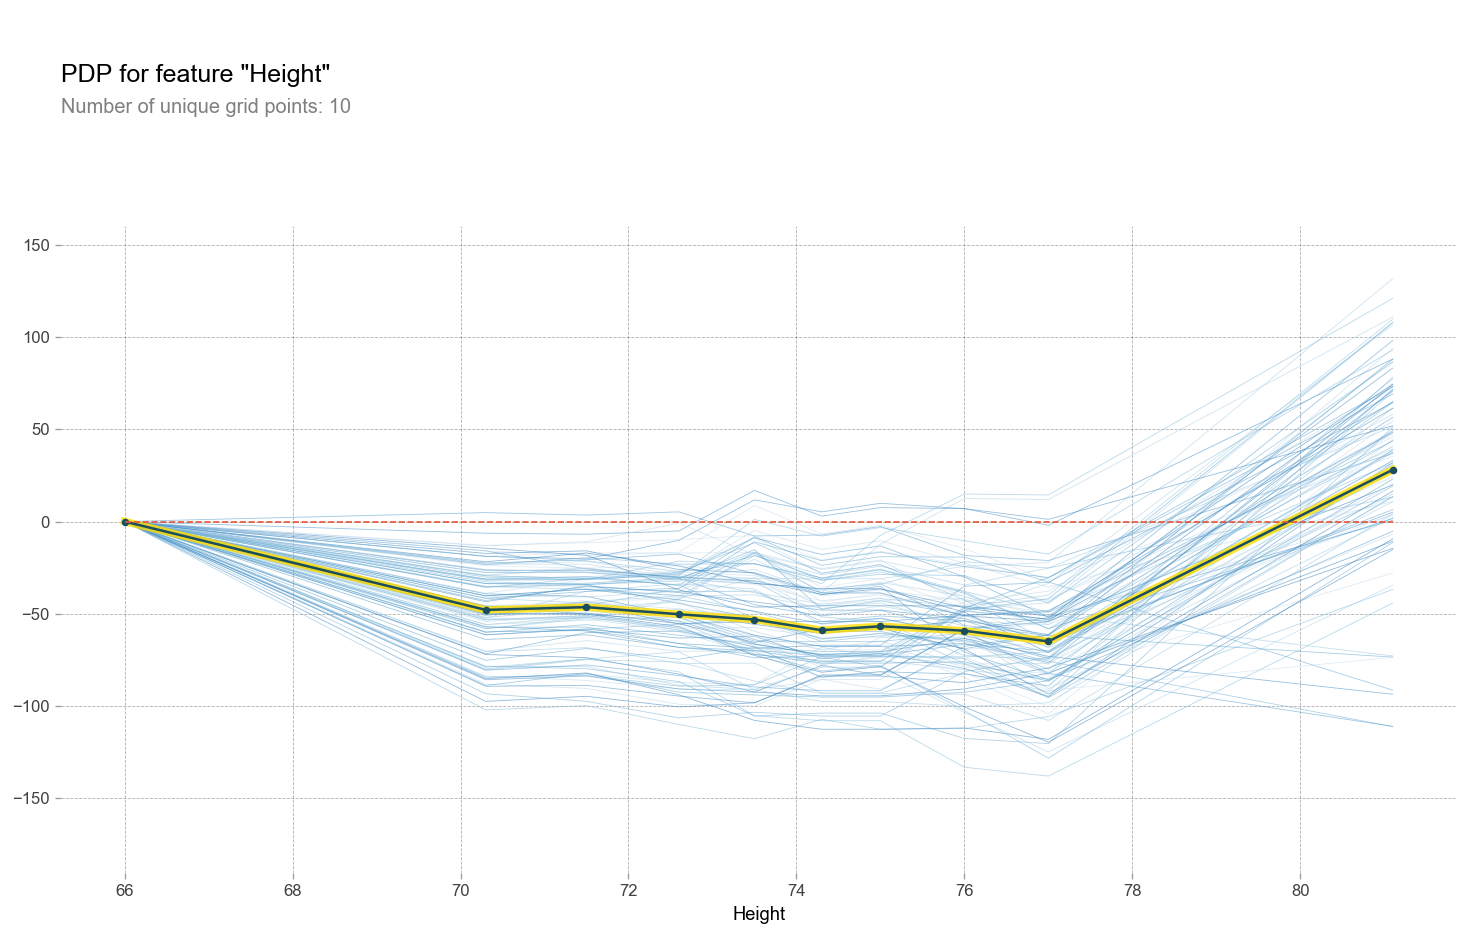

In [80]:
feature = 'Height'
isolate = pdp_isolate(
    model = xg,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature,
    num_grid_points=10
)
pdp_plot(isolate, feature_name=feature, plot_lines=100, frac_to_plot=100);

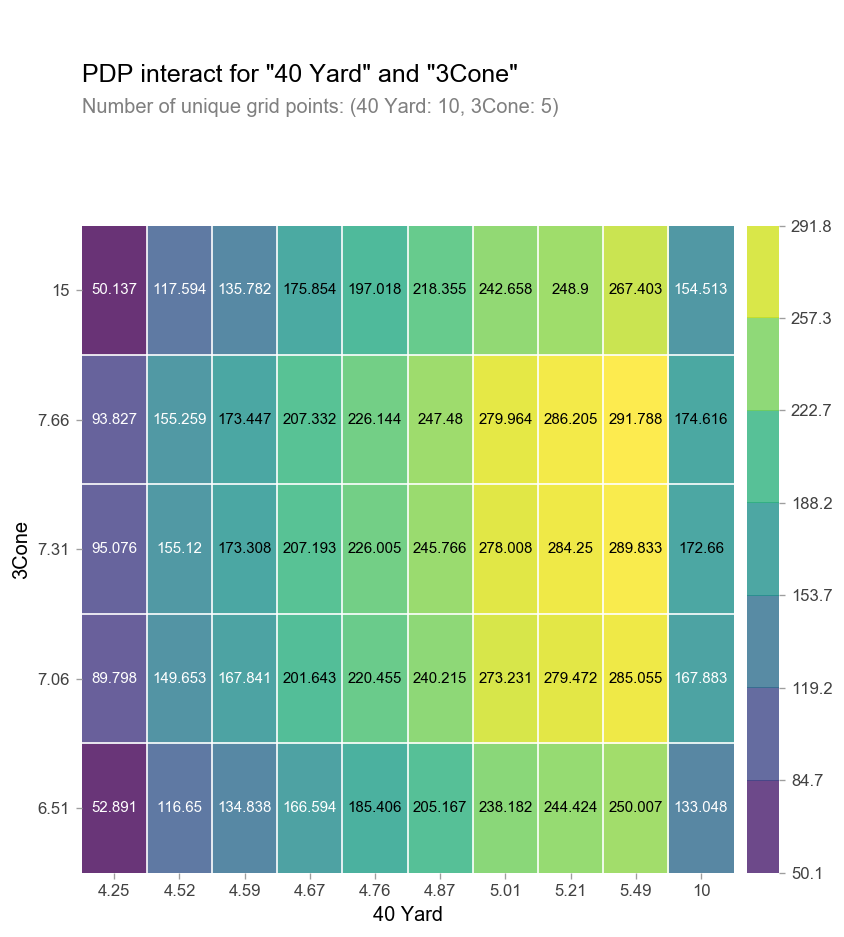

In [63]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['40 Yard', '3Cone']

interaction = pdp_interact(
    model=xg,
    dataset=X_test,
    model_features=X_test.columns,
    features=features,
    num_grid_points=[10,10]
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

10sec 40yard dash and 15sec 3cone were our imputed nan values! VISUAL THAT OUR HANDLING OF NAN'S ISN'T WORKING!

INSIGHT: Maybe we should just set the nan's to the max value? But then we would have an issue at that point...hmmmmmm....

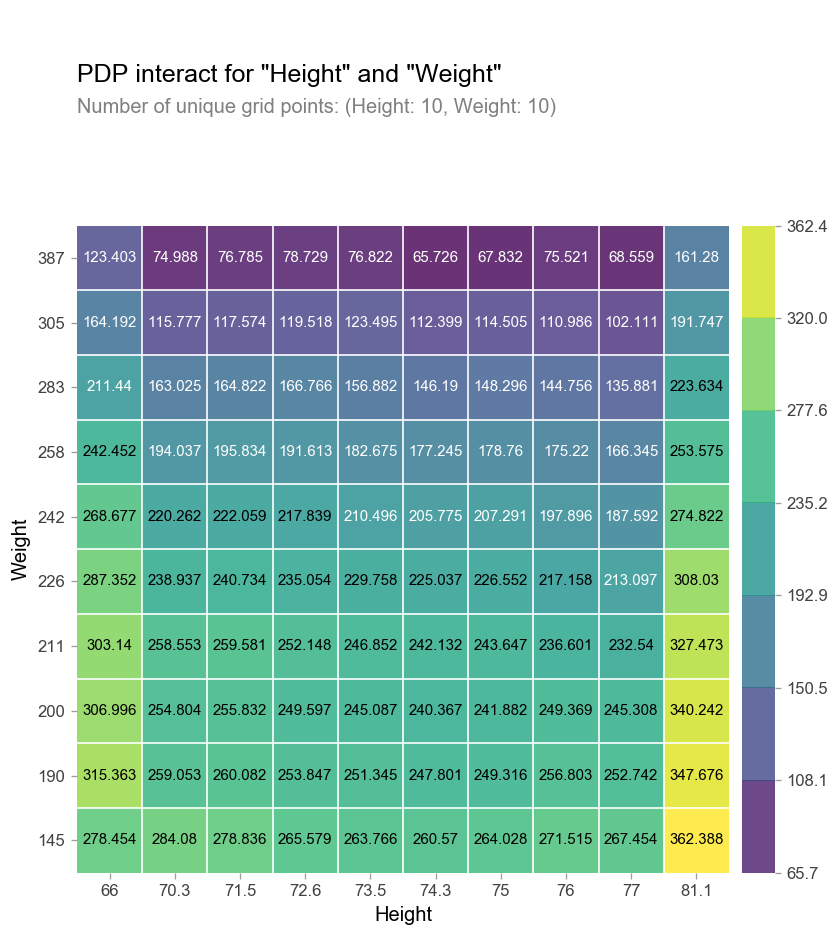

In [67]:
features=['Height', 'Weight']

interaction = pdp_interact(
    model=xg,
    dataset=X_test,
    model_features=X_test.columns,
    features=features,
    num_grid_points=[10,10]
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [70]:
pdp=interaction.pdp.pivot_table(
    columns=features[0],
    index=features[1],
    values='preds'
)[::-1]

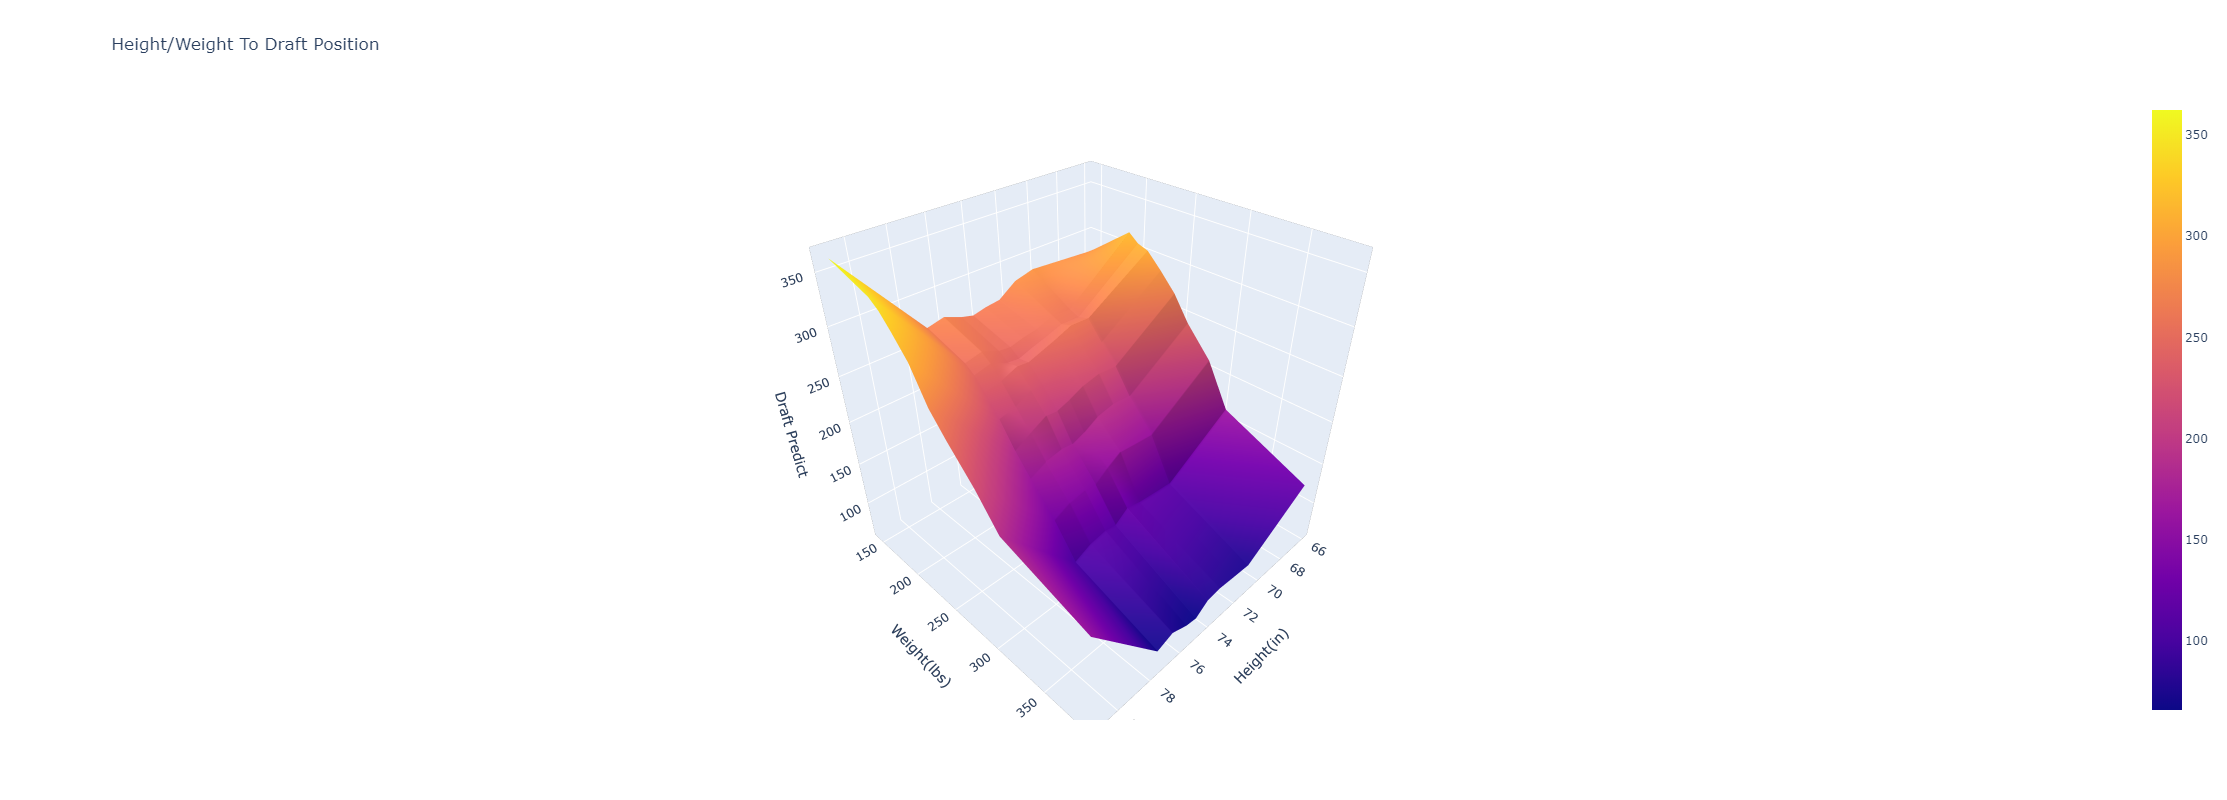

In [72]:
import plotly.graph_objects as go

surface = go.Surface(x=pdp.columns,
                     y=pdp.index,
                     z=pdp.values)

fig = go.Figure(surface)
fig.update_layout(title='Height/Weight To Draft Position', autosize=False,width=1000, height=800, scene=dict(
    xaxis = dict(title = 'Height(in)'),
    yaxis = dict(title = 'Weight(lbs)'),
    zaxis = dict(title = 'Draft Predict')))
fig.show()

## Maybe with a categorical feature?